# IV Curve Seminar

In [46]:
from numpy import array, arange, exp
from math import factorial
from scipy.optimize import curve_fit
from matplotlib.pyplot import scatter, plot, show, legend, xlabel, ylabel, ylim
from scipy.constants import Boltzmann, elementary_charge
import pandas as pd

# Measurements

In [18]:
df = pd.read_csv('iv_measurements.csv')
df

,d [cm],irrad [W/m2],V [V],R [ohms],R error +,R error -
0,60,920,11.8,1000000,1050000.00,950000.00
1,60,920,10.6,37,38.85,35.15
2,60,920,10.5,25,26.25,23.75
3,60,920,10.1,22,23.10,20.90
4,60,920,5.9,12,12.60,11.40
5,60,920,3.1,6,6.30,5.70
6,60,920,2.1,4,4.20,3.80
7,60,920,1.6,3,3.15,2.85


In [20]:
df['I [A]'] = df['V [V]'] / df['R [ohms]']
df['I err + [A]'] = df['V [V]'] / df['R error -']
df['I err - [A]'] = df['V [V]'] / df['R error +']
df['P [W]'] = df['V [V]'] * df['I [A]']
df['P err + [W]'] = df['V [V]'] * df['I err + [A]']
df['P err - [W]'] = df['V [V]'] * df['I err - [A]']
df['P avg [W]'] = ( df['P err + [W]'] + df['P err + [W]'] ) /2
df


,d [cm],irrad [W/m2],V [V],R [ohms],R error +,R error -,I [A],I err + [A],I err - [A],P [W],P err + [W],P err - [W],P avg [W]
0,60,920,11.8,1000000,1050000.00,950000.00,0.000012,0.000012,0.000011,0.000139,0.000147,0.000133,0.000147
1,60,920,10.6,37,38.85,35.15,0.286486,0.301565,0.272844,3.036757,3.196586,2.892149,3.196586
2,60,920,10.5,25,26.25,23.75,0.420000,0.442105,0.400000,4.410000,4.642105,4.200000,4.642105
3,60,920,10.1,22,23.10,20.90,0.459091,0.483254,0.437229,4.636818,4.880861,4.416017,4.880861
4,60,920,5.9,12,12.60,11.40,0.491667,0.517544,0.468254,2.900833,3.053509,2.762698,3.053509
5,60,920,3.1,6,6.30,5.70,0.516667,0.543860,0.492063,1.601667,1.685965,1.525397,1.685965
6,60,920,2.1,4,4.20,3.80,0.525000,0.552632,0.500000,1.102500,1.160526,1.050000,1.160526
7,60,920,1.6,3,3.15,2.85,0.533333,0.561404,0.507937,0.853333,0.898246,0.812698,0.898246


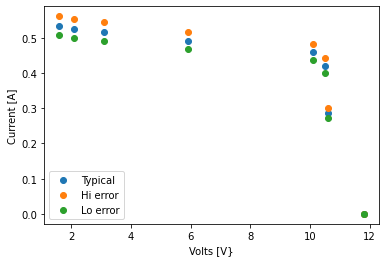

In [21]:
scatter(df['V [V]'], df['I [A]'], label='Typical')
scatter(df['V [V]'], df['I err + [A]'], label='Hi error')
scatter(df['V [V]'], df['I err - [A]'], label='Lo error')
legend()
xlabel('Volts [V}')
ylabel('Current [A]')
show()

# Curve fit

In [22]:
V = df['V [V]'].values 
I = df['I [A]'].values 

Simplified expression from [PV education article](https://www.pveducation.org/pvcdrom/solar-cell-operation/iv-curve#footnote1_zlgyr9m)
:

$ I(V) = I_L + I_S \ e^{ ( \frac{qV}{nkT} ) } $

In [50]:
n = 1.0					# ideality factor
k = Boltzmann 			# joules per kelvin
q = elementary_charge 	# couloumbs
T = 300.0 				# kelvin

def function(x, I_L, I_S):
	return I_L - I_S * ( exp(q*x / (n*k*T)) ) 

The above equation _should_ work, but the python non-linear least squares algorithm is unable to calculate the covariance matrix on the function `exp()`. 

So we need to do a taylor expansion of $e^x$:

$
e^x = 1 + x/1! + x^2/2! + x^3/3! ...
$

In [34]:
def function_with_taylor(x, I_L, I_S):
	taylor = 1
	for i in range(1,10):
		taylor += (q*x / (n*k*T))**i/factorial(i)
	return I_L - I_S * taylor	

Do the curve fit

In [35]:
parameters, _ = curve_fit(function_with_taylor, V, I)

I_L, I_S = parameters
print(f'I_L = {I_L}')
print(f'I_S = {I_S}')


I_L = 0.5308534574118514
I_S = 2.1177018253319535e-19


Plot with taylor-expanded function

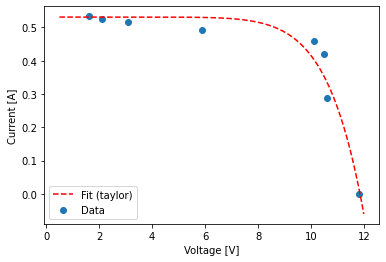

In [36]:
scatter(V, I, label='Data')

x = arange(0.5, 12, .01)
y = function_with_taylor(x, I_L, I_S)

plot(x, y, '--', color='red', label='Fit (taylor)')
legend()
xlabel('Voltage [V]')
ylabel('Current [A]')
show()

This doesn't work and I dont know why

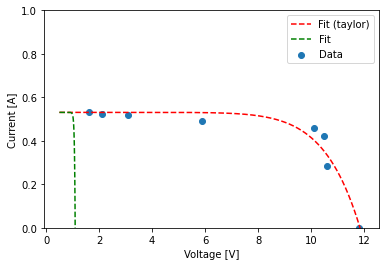

In [37]:
scatter(V, I, label='Data')

x = arange(0.5, 12, .01)
y1 = function_with_taylor(x, I_L, I_S)
y2 = function(x, I_L, I_S)

plot(x, y1, '--', color='red', label='Fit (taylor)')
plot(x, y2, '--', color='green', label='Fit')
legend()
xlabel('Voltage [V]')
ylabel('Current [A]')
ylim([0,1])
show()